<a href="https://colab.research.google.com/github/aio25-mix002/m03-p0301/blob/yen/Project_3_1_Sau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Thư viện**

In [1]:
import os
import re
import random
import warnings
from collections import Counter
from typing import List, Optional

#Khoa học dữ liệu + vẽ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Dữ liệu & mô hình ngôn ngữ
from datasets import load_dataset                 # Hugging Face Datasets
from sentence_transformers import SentenceTransformer  # Embeddings (E5, SBERT, …)

#Transformers baseline

#Tiền xử lý tiếng Anh (stopwords/synonyms)
import nltk
from nltk.corpus import wordnet as wn

#scikit-learn (train/test, vector hoá, model, đánh giá)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Cân bằng dữ liệu (imbalanced-learn)
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    _IMB_OK = True
except Exception:
    _IMB_OK = False
    warnings.warn("imbalanced-learn chưa cài; SMOTE/ROS/RUS sẽ bị tắt. Cài: pip install imbalanced-learn")


# import warnings
warnings.filterwarnings("ignore")

CACHE_DIR = "./cache"

In [2]:
# Tạo block cấu hình đường dẫn/ Figure/Report paths
from types import SimpleNamespace

FIG_ROOT = os.path.join("pdf", "Figures")
PATHS = SimpleNamespace(
    root=FIG_ROOT,
    balanced=os.path.join(FIG_ROOT, "balanced"),
    all_models=os.path.join(FIG_ROOT, "all_models"),
)

# Tạo thư mục
for d in (PATHS.root, PATHS.balanced, PATHS.all_models):
    os.makedirs(d, exist_ok=True)

#**2. Xử lý dữ liệu**

In [3]:
# Load the dataset from the specified cache directory
ds = load_dataset("UniverseTBD/arxiv-abstracts-large", cache_dir=CACHE_DIR)
ds

README.md:   0%|          | 0.00/810 [00:00<?, ?B/s]

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2292057 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [4]:
all_categories = ds['train']['categories'][:1000]
print(set(all_categories))

{'nlin.PS', 'cond-mat.str-el cond-mat.supr-con', 'physics.class-ph', 'cond-mat.dis-nn cond-mat.stat-mech', 'physics.comp-ph', 'cs.IT cs.AI math.IT q-bio.PE', 'q-bio.OT', 'math-ph hep-th math.MP', 'nlin.SI cond-mat.stat-mech hep-th', 'math.PR math.ST stat.CO stat.TH', 'cs.CC cs.DM', 'nucl-th', 'cond-mat.str-el cond-mat.soft', 'cond-mat.str-el cond-mat.stat-mech', 'cond-mat.other hep-th quant-ph', 'math.DG math.CA', 'cs.CC', 'cs.IT cs.LG math.IT', 'math.PR math.AG', 'math.RT', 'hep-ph astro-ph', 'astro-ph gr-qc hep-ph', 'cond-mat.str-el cond-mat.other', 'cond-mat.mtrl-sci cond-mat.soft', 'math.DG', 'math.AP math-ph math.MP', 'q-bio.PE', 'hep-th astro-ph hep-ph', 'cond-mat.other nlin.PS', 'cond-mat.other cond-mat.stat-mech', 'nlin.CD', 'math.RT math.GR', 'cond-mat.other', 'cond-mat.soft nlin.PS physics.flu-dyn', 'cs.DM cs.LO', 'cond-mat.supr-con cond-mat.mes-hall quant-ph', 'math.AG math.CA', 'math.SG', 'hep-th cond-mat.stat-mech', 'cs.PF cs.CR', 'nucl-ex', 'physics.optics physics.class-p

In [5]:
all_categories = ds['train']['categories']
category_set = set()

# Collect unique labels
for category in all_categories:
    parts = category.split(' ')
    for part in parts:
        topic = part.split('.')[0]
        category_set.add(topic)

# Sort the labels and print them
sorted_categories= sorted(list(category_set), key=lambda x: x.lower())
print(f'There are {len(sorted_categories)} unique primary categories in the dataset:')
for category in sorted_categories:
    print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [6]:
# load 1000 samples with single label belonging to specific categories
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
for s in ds['train']:
    if len(s['categories'].split(' ')) != 1:
        continue

    cur_category = s['categories'].strip().split('.')[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue

    samples.append(s)

    if len(samples) >= 1000:
        break
print(f"Number of samples: {len(samples)}")

for sample in samples[:3]:
    print(f"Category: {sample['categories']}")
    print("Abstract:", sample['abstract'])
    print("#" * 20 + "\n")

Number of samples: 1000
Category: physics.gen-ph
Abstract:   The evolution of Earth-Moon system is described by the dark matter field
fluid model proposed in the Meeting of Division of Particle and Field 2004,
American Physical Society. The current behavior of the Earth-Moon system agrees
with this model very well and the general pattern of the evolution of the
Moon-Earth system described by this model agrees with geological and fossil
evidence. The closest distance of the Moon to Earth was about 259000 km at 4.5
billion years ago, which is far beyond the Roche's limit. The result suggests
that the tidal friction may not be the primary cause for the evolution of the
Earth-Moon system. The average dark matter field fluid constant derived from
Earth-Moon system data is 4.39 x 10^(-22) s^(-1)m^(-1). This model predicts
that the Mars's rotation is also slowing with the angular acceleration rate
about -4.38 x 10^(-22) rad s^(-2).

####################

Category: math.CO
Abstract:   We show 

In [7]:
preprocessed_samples = []
for s in samples:
    abstract = s['abstract']

    # Remove \n characters in the middle and leading/trailing spaces
    abstract = abstract.strip().replace("\n", " ")

    # Remove special characters
    abstract = re.sub(r'[^\w\s]', '', abstract)

    # Remove digits
    abstract = re.sub(r'\d+', '', abstract)

    # Remove extra spaces
    abstract = re.sub(r'\s+', ' ', abstract).strip()

    # Convert to lower case
    abstract = abstract.lower()

    # for the label, we only keep the first part
    parts = s['categories'].split(' ')
    category = parts[0].split('.')[0]

    preprocessed_samples.append({
        "text": abstract,
        "label": category
    })

# print first 3 preprocessed samples
for sample in preprocessed_samples[:3]:
    print(f"Label: {sample['label']}")
    print("Text:", sample['text'])
    print("#" * 20 + "\n")

Label: physics
Text: the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about km at billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is x sm this model predicts that the marss rotation is also slowing with the angular acceleration rate about x rad s
####################

Label: math
Text: we show that a determinant of stirling cycle numbers counts unlabeled acyclic singlesource automata the proof involves a bijection from 

In [8]:
labels = set([s['label'] for s in preprocessed_samples])
# Sort and print unique labels
sorted_labels = sorted(labels)
for label in sorted_labels:
    print(label)

astro-ph
cond-mat
cs
math
physics


In [9]:
label_to_id = {label: i for i, label in enumerate(sorted_labels)}
id_to_label = {i: label for i, label in enumerate(sorted_labels)}

# Print label to ID mapping
print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} --> {id_}")

Label to ID mapping:
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [10]:
X_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


# **3. Tăng cường dữ liệu**

In [11]:
# 🔁 Data Augmentation + Class-Balanced Upsampling (put this right after train_test_split)

# ⚙️ Config
AUGMENT_ENABLED      = True      # tắt/mở augmentation
TARGET_PER_CLASS     = 300       # mỗi lớp sẽ được tăng lên tối đa mức này (hoặc max hiện có, tuỳ lớp)
ALPHA_DELETE         = 0.10      # xác suất xoá từ
ALPHA_SWAP           = 0.10      # tỷ lệ hoán vị ~ (ALPHA_SWAP * số từ)
ALPHA_SYNONYM_RATIO  = 0.10      # tỷ lệ từ sẽ được thay bằng đồng nghĩa (nếu có wordnet)
NUM_AUG_PER_SAMPLE   = 1         # mỗi văn bản gốc sinh ra bao nhiêu biến thể
RANDOM_SEED          = 42

random.seed(RANDOM_SEED)

#WordNet synonyms
try:
    import nltk
    nltk.data.find('corpora/wordnet')
except Exception:
    try:
        import nltk
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
    except Exception:
        pass

try:
    from nltk.corpus import wordnet as wn
    _WORDNET_OK = True
except Exception:
    _WORDNET_OK = False

def _tokenize_simple(s: str) -> List[str]:
    return s.split()

def _random_deletion(tokens: List[str], p: float) -> List[str]:
    if not tokens:
        return tokens
    out = [t for t in tokens if random.random() > p]
    return out if out else tokens  # không để rỗng

def _random_swap(tokens: List[str], n_swaps: int) -> List[str]:
    if len(tokens) < 2 or n_swaps <= 0:
        return tokens
    tokens = tokens.copy()
    for _ in range(n_swaps):
        i, j = random.sample(range(len(tokens)), 2)
        tokens[i], tokens[j] = tokens[j], tokens[i]
    return tokens

def _get_synonyms(word: str) -> List[str]:
    if not _WORDNET_OK or not word.isalpha():
        return []
    syns = set()
    for syn in wn.synsets(word):
        for lem in syn.lemmas():
            w = lem.name().replace('_', ' ').lower()
            if w != word:
                syns.add(w)
    return list(syns)

def _random_synonym_replace(tokens: List[str], ratio: float) -> List[str]:
    if not _WORDNET_OK or ratio <= 0 or not tokens:
        return tokens
    tokens = tokens.copy()
    n_changes = max(1, int(len(tokens) * ratio))
    idxs = list(range(len(tokens)))
    random.shuffle(idxs)
    changed = 0
    for i in idxs:
        syns = _get_synonyms(tokens[i])
        if syns:
            tokens[i] = random.choice(syns)
            changed += 1
        if changed >= n_changes:
            break
    return tokens

def eda_augment(text: str,
                alpha_del=ALPHA_DELETE,
                alpha_swap=ALPHA_SWAP,
                alpha_syn=ALPHA_SYNONYM_RATIO,
                num_aug=NUM_AUG_PER_SAMPLE) -> List[str]:
    """
    EDA cơ bản: xoá, hoán vị, thay từ đồng nghĩa (nếu có).
    """
    out = []
    base_tokens = _tokenize_simple(text)
    for _ in range(num_aug):
        tokens = base_tokens
        # xoá ngẫu nhiên
        tokens = _random_deletion(tokens, alpha_del)
        # hoán vị ngẫu nhiên
        n_swaps = max(1, int(len(tokens) * alpha_swap)) if len(tokens) > 1 else 0
        tokens = _random_swap(tokens, n_swaps)
        # thay từ đồng nghĩa
        tokens = _random_synonym_replace(tokens, alpha_syn)
        out.append(' '.join(tokens))
    return out

def augment_and_balance(X_train: List[str],
                        y_train: List[int],
                        target_per_class: int = TARGET_PER_CLASS,
                        seed: int = RANDOM_SEED):
    """
    Tăng cường + cân bằng theo lớp cho tới khi mỗi lớp đạt ít nhất target_per_class
    (hoặc tới mức gần nhất có thể).
    """
    random.seed(seed)
    X_train = list(X_train)
    y_train = list(y_train)

    counts = Counter(y_train)
    classes = sorted(counts.keys())
    cur_max = max(counts.values()) if counts else 0
    target = max(min(target_per_class, max(cur_max, 1)), 1)

    # Gom văn bản theo lớp
    by_class = {c: [x for x, y in zip(X_train, y_train) if y == c] for c in classes}

    X_aug, y_aug = [], []
    for c in classes:
        texts = by_class[c]
        need = max(0, target - len(texts))
        if need == 0 or not texts:
            continue

        # Lặp qua văn bản gốc, sinh biến thể cho tới khi đủ
        i = 0
        while need > 0:
            t = texts[i % len(texts)]
            for aug in eda_augment(t):
                X_aug.append(aug)
                y_aug.append(c)
                need -= 1
                if need <= 0:
                    break
            i += 1

    # Ghép vào train
    X_new = X_train + X_aug
    y_new = y_train + y_aug

    after = Counter(y_new)
    print("🔧 Augmented per-class counts:", dict(after))
    print(f"🔼 Train size: {len(X_train)} → {len(X_new)} (added {len(X_aug)})")
    return X_new, y_new

# Thực thi augmentation (nếu bật)
if AUGMENT_ENABLED:
    X_train, y_train = augment_and_balance(
        X_train, y_train, target_per_class=TARGET_PER_CLASS, seed=RANDOM_SEED
    )
else:
    print("Augmentation disabled — skipping.")

🔧 Augmented per-class counts: {1: 300, 0: 347, 4: 300, 3: 300, 2: 300}
🔼 Train size: 800 → 1547 (added 747)


In [22]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow  = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)

In [23]:
#EmbeddingVectorizer
class EmbeddingVectorizer:
    def __init__(self, model_name: str = "intfloat/multilingual-e5-base",
                 normalize: bool = True, device: Optional[str] = None):
        self.model = SentenceTransformer(model_name, device=device)
        self.normalize = normalize

    def _format_inputs(self, texts: List[str], mode: str = "query") -> List[str]:
        if mode == "raw":
            return texts
        if mode not in {"query", "passage"}:
            raise ValueError("mode phải là 'query', 'passage' hoặc 'raw'")
        return [f"{mode}: {t.strip()}" for t in texts]

    def transform_numpy(self, texts: List[str], mode: str = "query") -> np.ndarray:
        inputs = self._format_inputs(texts, mode)
        embs = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return np.array(embs)

In [24]:
#Tạo embedding
embedding_vectorizer = EmbeddingVectorizer()  # mặc định 'intfloat/multilingual-e5-base'
X_train_embeddings = embedding_vectorizer.transform_numpy(X_train)  # shape (N, 768)
X_test_embeddings  = embedding_vectorizer.transform_numpy(X_test)

# **4. Cân bằng dữ liệu train**

In [16]:
BALANCE_BOW      = "over"   # 'none' | 'over' | 'under'  (không khuyến nghị 'smote' cho sparse)
BALANCE_TFIDF    = "over"   # 'none' | 'over' | 'under'
BALANCE_EMB      = "smote"  # 'none' | 'over' | 'under' | 'smote' (SMOTE tốt cho embeddings)

RANDOM_STATE     = 42

def _print_counts(y, note):
    cnt = Counter(y)
    print(f"{note} — số mẫu theo lớp:", dict(sorted(cnt.items())))

# Thử dùng imblearn; nếu thiếu thì fallback thủ công cho 'over'/'under'
try:
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.over_sampling import SMOTE
    _IMB_OK = True
except Exception:
    _IMB_OK = False
    print("⚠️ Thiếu imblearn — sẽ dùng fallback đơn giản cho over/under. Cài bằng: pip install imbalanced-learn")

In [18]:
def _fallback_resample_over(X, y):
    """Oversample thủ công đến max_count."""
    y = np.asarray(y)
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    idx_all = np.arange(len(y))
    new_idx = []
    for c in classes:
        idx_c = idx_all[y == c]
        if len(idx_c) == 0:
            continue
        reps = int(np.ceil(max_count / len(idx_c)))
        tiled = np.tile(idx_c, reps)[:max_count]
        new_idx.append(tiled)
    new_idx = np.concatenate(new_idx)
    if hasattr(X, "toarray"):  # sparse
        X_new = X[new_idx]
    else:
        X_new = X[new_idx] if isinstance(X, np.ndarray) else [X[i] for i in new_idx]
    y_new = y[new_idx]
    return X_new, y_new

def _fallback_resample_under(X, y):
    """Undersample thủ công xuống min_count."""
    y = np.asarray(y)
    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    rng = np.random.default_rng(RANDOM_STATE)
    idx_all = np.arange(len(y))
    new_idx = []
    for c in classes:
        idx_c = idx_all[y == c]
        take = rng.choice(idx_c, size=min_count, replace=False)
        new_idx.append(take)
    new_idx = np.concatenate(new_idx)
    rng.shuffle(new_idx)
    if hasattr(X, "toarray"):  # sparse
        X_new = X[new_idx]
    else:
        X_new = X[new_idx] if isinstance(X, np.ndarray) else [X[i] for i in new_idx]
    y_new = y[new_idx]
    return X_new, y_new

def make_balanced(X, y, strategy: str, is_sparse: bool, for_embeddings: bool = False):
    """
    strategy: 'none' | 'over' | 'under' | 'smote'
    is_sparse: True cho BoW/TF-IDF; False cho embeddings
    for_embeddings: True nếu là embeddings (dense) => cho phép SMOTE
    """
    if strategy == "none":
        return X, y

    if strategy == "smote":
        if not for_embeddings or is_sparse:
            print("⚠️ Bỏ qua SMOTE cho dữ liệu sparse (BoW/TF-IDF). Dùng 'over' thay thế.")
            strategy = "over"
        elif not _IMB_OK:
            print("⚠️ Thiếu imblearn — không dùng được SMOTE. Dùng 'over' thay thế.")
            strategy = "over"

    if not _IMB_OK and strategy in {"over", "under"}:
        # Fallback thủ công
        return (_fallback_resample_over(X, y) if strategy == "over"
                else _fallback_resample_under(X, y))

    # Dùng imblearn
    if strategy == "over":
        sampler = RandomOverSampler(random_state=RANDOM_STATE)
    elif strategy == "under":
        sampler = RandomUnderSampler(random_state=RANDOM_STATE)
    elif strategy == "smote":
        # SMOTE cho embeddings (dense)
        sampler = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
    else:
        return X, y

    # imblearn hỗ trợ y như mảng 1D
    y_arr = np.asarray(y)
    X_bal, y_bal = sampler.fit_resample(X, y_arr)
    return X_bal, y_bal

In [25]:
# ===== Thực thi cân bằng =====
_print_counts(y_train, "Trước cân bằng")

# BoW (sparse)
is_sparse_bow = hasattr(X_train_bow, "toarray")
X_train_bow_bal, y_train_bow_bal = make_balanced(
    X_train_bow, y_train, strategy=BALANCE_BOW, is_sparse=is_sparse_bow, for_embeddings=False
)
_print_counts(y_train_bow_bal, f"BoW sau cân bằng ({BALANCE_BOW})")

# TF-IDF (sparse)
is_sparse_tfidf = hasattr(X_train_tfidf, "toarray")
X_train_tfidf_bal, y_train_tfidf_bal = make_balanced(
    X_train_tfidf, y_train, strategy=BALANCE_TFIDF, is_sparse=is_sparse_tfidf, for_embeddings=False
)
_print_counts(y_train_tfidf_bal, f"TF-IDF sau cân bằng ({BALANCE_TFIDF})")

# Embeddings (dense) — ưu tiên SMOTE
is_sparse_emb = False
X_train_emb_bal, y_train_emb_bal = make_balanced(
    X_train_embeddings, y_train, strategy=BALANCE_EMB, is_sparse=is_sparse_emb, for_embeddings=True
)
_print_counts(y_train_emb_bal, f"Embeddings sau cân bằng ({BALANCE_EMB})")

Trước cân bằng — số mẫu theo lớp: {0: 347, 1: 300, 2: 300, 3: 300, 4: 300}
BoW sau cân bằng (over) — số mẫu theo lớp: {np.int64(0): 347, np.int64(1): 347, np.int64(2): 347, np.int64(3): 347, np.int64(4): 347}
TF-IDF sau cân bằng (over) — số mẫu theo lớp: {np.int64(0): 347, np.int64(1): 347, np.int64(2): 347, np.int64(3): 347, np.int64(4): 347}
Embeddings sau cân bằng (smote) — số mẫu theo lớp: {np.int64(0): 347, np.int64(1): 347, np.int64(2): 347, np.int64(3): 347, np.int64(4): 347}


# **5. Huấn luyện lại trên tập đã cân bằng**


In [26]:
# 🎯 Confusion matrices — Sau cân bằng (và so sánh nếu có bản "pre")
# Bảo đảm danh sách nhãn hiển thị đúng thứ tự id
if 'sorted_labels' not in globals():
    # fallback theo id xuất hiện trong y_test
    uniq = sorted(set(y_test))
    sorted_labels = [str(i) for i in uniq]
labels_idx = list(range(len(sorted_labels)))

In [27]:
# ===== Kiểm tra biến cần thiết =====
_required = [
    'X_train_bow_bal','y_train_bow_bal','X_test_bow',
    'X_train_tfidf_bal','y_train_tfidf_bal','X_test_tfidf',
    'X_train_emb_bal','y_train_emb_bal','X_test_embeddings',
    'y_test'
]
_missing = [v for v in _required if v not in globals()]
assert not _missing, f"Thiếu biến: {_missing}. Hãy chạy cell tiền xử lý / vector hóa trước."

# ===== Labels hiển thị =====
if 'sorted_labels' not in globals():
    if 'id_to_label' in globals() and isinstance(id_to_label, dict):
        sorted_labels = [id_to_label[i] for i in range(len(id_to_label))]
    else:
        uniq = sorted(set(list(y_train_bow_bal) + list(y_test)))
        sorted_labels = [str(i) for i in uniq]

# ===== Helpers chung =====
def _to_dense(X): # cho GaussianNB
    return X.toarray() if hasattr(X, "toarray") else X

def _safe_report(y_true, y_pred):
    return classification_report(y_true, y_pred, target_names=sorted_labels, output_dict=True)

def _summarize(name, y_true, y_pred):
    return dict(
        model_feature=name,
        accuracy=accuracy_score(y_true, y_pred),
        f1_macro=f1_score(y_true, y_pred, average="macro"),
        f1_weighted=f1_score(y_true, y_pred, average="weighted"),
    )

In [28]:
# KNN
def train_and_test_knn(X_tr, y_tr, X_te, y_te, n_neighbors: int = 5):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_tr, y_tr)
    return clf.predict(X_te)

knn_bow_labels   = train_and_test_knn(X_train_bow_bal,   y_train_bow_bal,   X_test_bow,        y_test)
knn_tfidf_labels = train_and_test_knn(X_train_tfidf_bal, y_train_tfidf_bal, X_test_tfidf,      y_test)
knn_emb_labels   = train_and_test_knn(X_train_emb_bal,   y_train_emb_bal,   X_test_embeddings, y_test)

In [29]:
# Decision Tree
def train_and_test_decision_tree_bal(X_tr, y_tr, X_te, y_te, use_class_weight=True, random_state: int = 42):
    cw = "balanced" if use_class_weight else None
    clf = DecisionTreeClassifier(random_state=random_state, class_weight=cw)
    clf.fit(X_tr, y_tr)
    return clf.predict(X_te)

dt_bow_labels   = train_and_test_decision_tree_bal(X_train_bow_bal,   y_train_bow_bal,   X_test_bow,        y_test, use_class_weight=True)
dt_tfidf_labels = train_and_test_decision_tree_bal(X_train_tfidf_bal, y_train_tfidf_bal, X_test_tfidf,      y_test, use_class_weight=True)
dt_emb_labels   = train_and_test_decision_tree_bal(X_train_emb_bal,   y_train_emb_bal,   X_test_embeddings, y_test, use_class_weight=True)

In [30]:
# Naive Bayes
def train_and_test_naive_bayes(X_tr, y_tr, X_te, y_te):
    clf = GaussianNB()
    clf.fit(_to_dense(X_tr), y_tr)
    return clf.predict(_to_dense(X_te))

nb_bow_labels   = train_and_test_naive_bayes(X_train_bow_bal,   y_train_bow_bal,   X_test_bow,        y_test)
nb_tfidf_labels = train_and_test_naive_bayes(X_train_tfidf_bal, y_train_tfidf_bal, X_test_tfidf,      y_test)
nb_emb_labels   = train_and_test_naive_bayes(X_train_emb_bal,   y_train_emb_bal,   X_test_embeddings, y_test)

In [31]:
# ===== 2) LinearSVC / Logistic Regression / Ridge =====
def _fit_eval(model, X_tr, y_tr, X_te, y_te, name: str, to_dense: bool = False):
    if to_dense:
        X_tr = _to_dense(X_tr); X_te = _to_dense(X_te)
    model.fit(X_tr, y_tr)
    return model.predict(X_te)

In [32]:
svc_bow_labels   = _fit_eval(LinearSVC(C=1.0, class_weight='balanced', random_state=42),
                             X_train_bow_bal, y_train_bow_bal, X_test_bow, y_test, "LinearSVC — BoW")
svc_tfidf_labels = _fit_eval(LinearSVC(C=1.0, class_weight='balanced', random_state=42),
                             X_train_tfidf_bal, y_train_tfidf_bal, X_test_tfidf, y_test, "LinearSVC — TF-IDF")
svc_emb_labels   = _fit_eval(LinearSVC(C=1.0, class_weight='balanced', random_state=42),
                             X_train_emb_bal, y_train_emb_bal, X_test_embeddings, y_test, "LinearSVC — Embeddings")

log_bow_labels   = _fit_eval(LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=2000,
                                                class_weight='balanced', random_state=42),
                             X_train_bow_bal, y_train_bow_bal, X_test_bow, y_test, "LogReg — BoW")
log_tfidf_labels = _fit_eval(LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=2000,
                                                class_weight='balanced', random_state=42),
                             X_train_tfidf_bal, y_train_tfidf_bal, X_test_tfidf, y_test, "LogReg — TF-IDF")
log_emb_labels   = _fit_eval(LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=2000,
                                                class_weight='balanced', random_state=42),
                             X_train_emb_bal, y_train_emb_bal, X_test_embeddings, y_test, "LogReg — Embeddings")

ridge_bow_labels   = _fit_eval(RidgeClassifier(alpha=1.0, class_weight='balanced', random_state=42),
                               X_train_bow_bal, y_train_bow_bal, X_test_bow, y_test, "Ridge — BoW")
ridge_tfidf_labels = _fit_eval(RidgeClassifier(alpha=1.0, class_weight='balanced', random_state=42),
                               X_train_tfidf_bal, y_train_tfidf_bal, X_test_tfidf, y_test, "Ridge — TF-IDF")
ridge_emb_labels   = _fit_eval(RidgeClassifier(alpha=1.0, class_weight='balanced', random_state=42),
                               X_train_emb_bal, y_train_emb_bal, X_test_embeddings, y_test, "Ridge — Embeddings")

In [36]:
# ===== 3) Bảng tóm tắt nhanh =====
rows = []
rows += [_summarize("KNN — BoW",         y_test, knn_bow_labels)]
rows += [_summarize("KNN — TF-IDF",      y_test, knn_tfidf_labels)]
rows += [_summarize("KNN — Embeddings",  y_test, knn_emb_labels)]

rows += [_summarize("Decision Tree — BoW",        y_test, dt_bow_labels)]
rows += [_summarize("Decision Tree — TF-IDF",     y_test, dt_tfidf_labels)]
rows += [_summarize("Decision Tree — Embeddings", y_test, dt_emb_labels)]

rows += [_summarize("Naive Bayes — BoW",         y_test, nb_bow_labels)]
rows += [_summarize("Naive Bayes — TF-IDF",      y_test, nb_tfidf_labels)]
rows += [_summarize("Naive Bayes — Embeddings",  y_test, nb_emb_labels)]

rows += [_summarize("LinearSVC — BoW",        y_test, svc_bow_labels)]
rows += [_summarize("LinearSVC — TF-IDF",     y_test, svc_tfidf_labels)]
rows += [_summarize("LinearSVC — Embeddings", y_test, svc_emb_labels)]

rows += [_summarize("LogReg — BoW",        y_test, log_bow_labels)]
rows += [_summarize("LogReg — TF-IDF",     y_test, log_tfidf_labels)]
rows += [_summarize("LogReg — Embeddings", y_test, log_emb_labels)]

rows += [_summarize("Ridge — BoW",        y_test, ridge_bow_labels)]
rows += [_summarize("Ridge — TF-IDF",     y_test, ridge_tfidf_labels)]
rows += [_summarize("Ridge — Embeddings", y_test, ridge_emb_labels)]

results_df_all = (pd.DataFrame(rows)
                  .sort_values(["f1_macro","accuracy"], ascending=False)
                  .reset_index(drop=True))

print("\n🏁 Tổng hợp (top 10 theo F1-macro):")
try:
    from IPython.display import display
    display(results_df_all.head(10))
except Exception:
    print(results_df_all.head(10))

best = results_df_all.iloc[0]
print(f"🏆 Best: {best['model_feature']} | Acc={best['accuracy']:.4f} | F1-macro={best['f1_macro']:.4f}")


🏁 Tổng hợp (top 10 theo F1-macro):


,model_feature,accuracy,f1_macro,f1_weighted
0,Ridge — Embeddings,0.905,0.770715,0.893415
1,LogReg — Embeddings,0.895,0.723645,0.881479
2,Naive Bayes — Embeddings,0.890,0.711385,0.878544
3,KNN — Embeddings,0.880,0.700821,0.863892
4,LinearSVC — Embeddings,0.895,0.695857,0.881097
5,LinearSVC — TF-IDF,0.895,0.655015,0.873433
6,Ridge — TF-IDF,0.890,0.641625,0.866482
7,LogReg — TF-IDF,0.885,0.638489,0.861825
8,KNN — TF-IDF,0.815,0.605423,0.810857
9,Naive Bayes — BoW,0.845,0.600705,0.816304


🏆 Best: Ridge — Embeddings | Acc=0.9050 | F1-macro=0.7707


# **6. Tổng hợp kết quả + Vẽ tất cả mô hình**

🏁 Bảng tổng hợp (top 12 theo F1-macro):


,model_feature,algo,repr,accuracy,f1_macro,f1_weighted
0,Ridge — Embeddings,Ridge,Embeddings,0.905,0.770715,0.893415
1,LogReg — Embeddings,LogReg,Embeddings,0.895,0.723645,0.881479
2,Naive Bayes — Embeddings,Naive Bayes,Embeddings,0.890,0.711385,0.878544
3,KNN — Embeddings,KNN,Embeddings,0.880,0.700821,0.863892
4,LinearSVC — Embeddings,LinearSVC,Embeddings,0.895,0.695857,0.881097
5,LinearSVC — TF-IDF,LinearSVC,TF-IDF,0.895,0.655015,0.873433
6,Ridge — TF-IDF,Ridge,TF-IDF,0.890,0.641625,0.866482
7,LogReg — TF-IDF,LogReg,TF-IDF,0.885,0.638489,0.861825
8,KNN — TF-IDF,KNN,TF-IDF,0.815,0.605423,0.810857
9,Naive Bayes — BoW,Naive Bayes,BoW,0.845,0.600705,0.816304


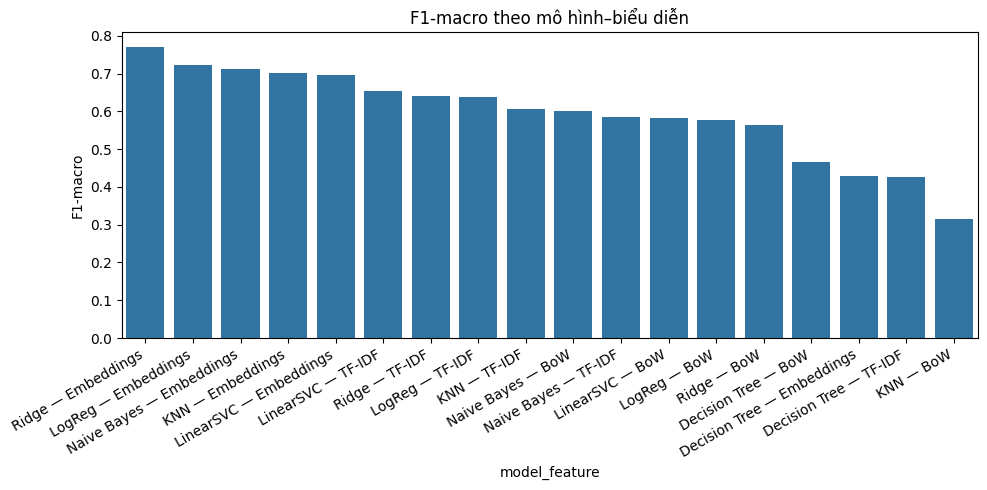

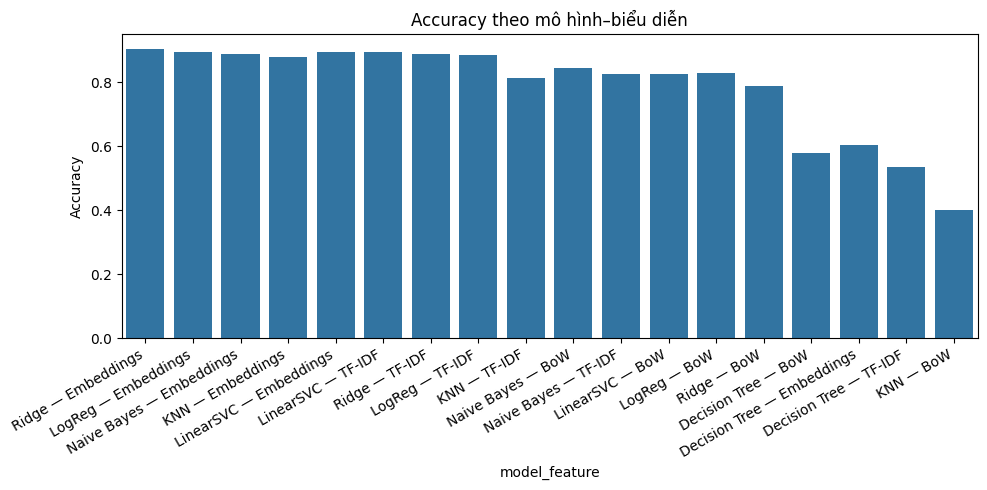

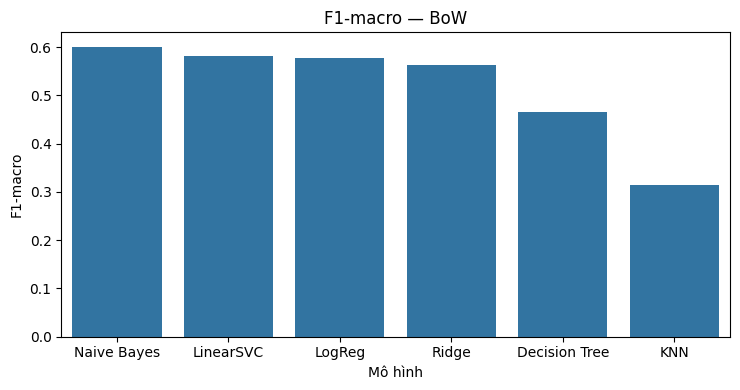

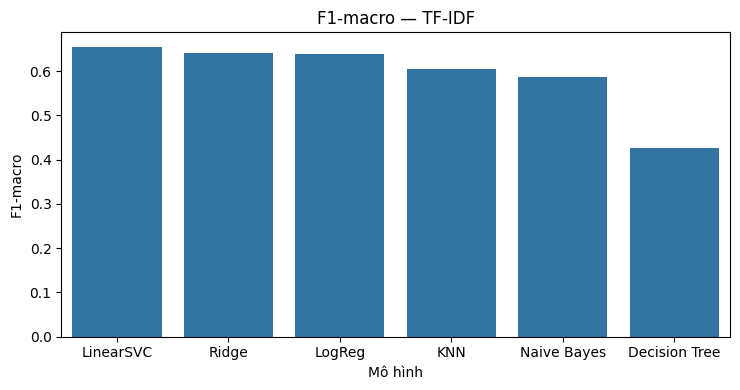

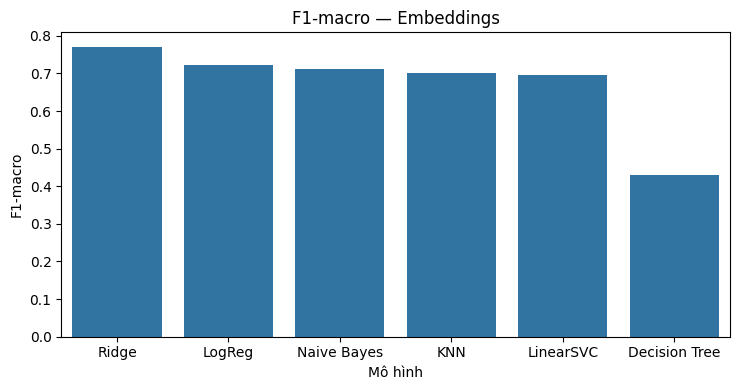

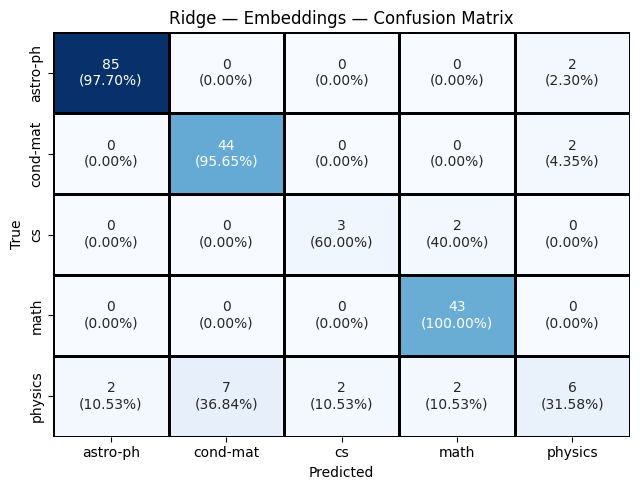

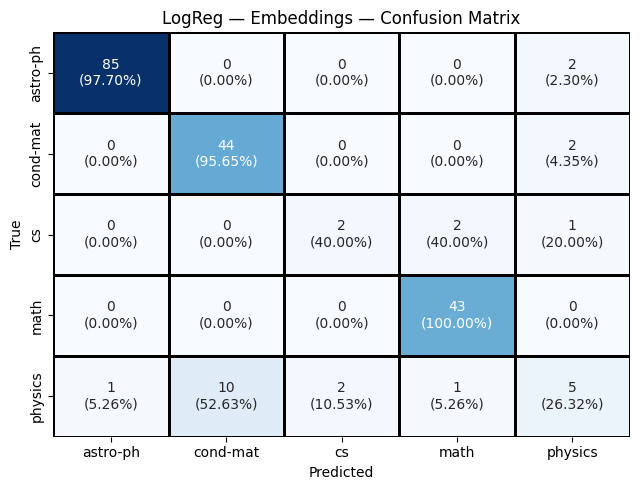

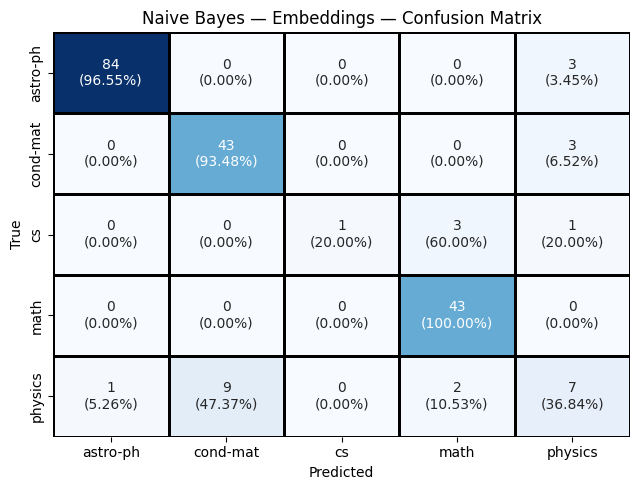

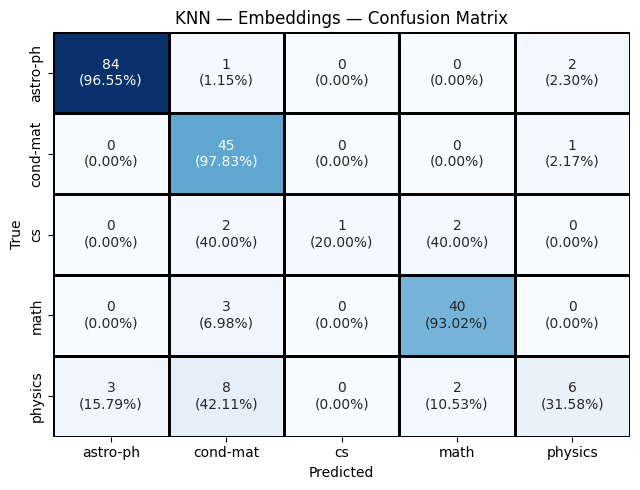

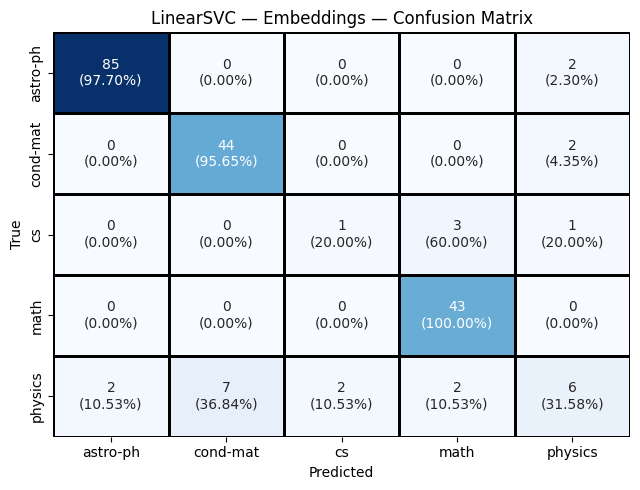

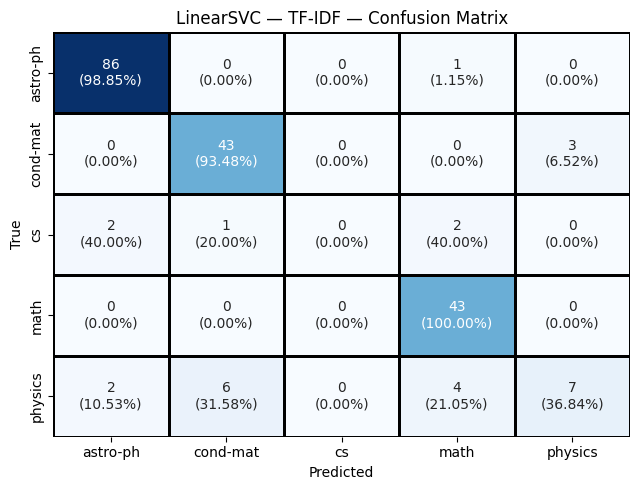

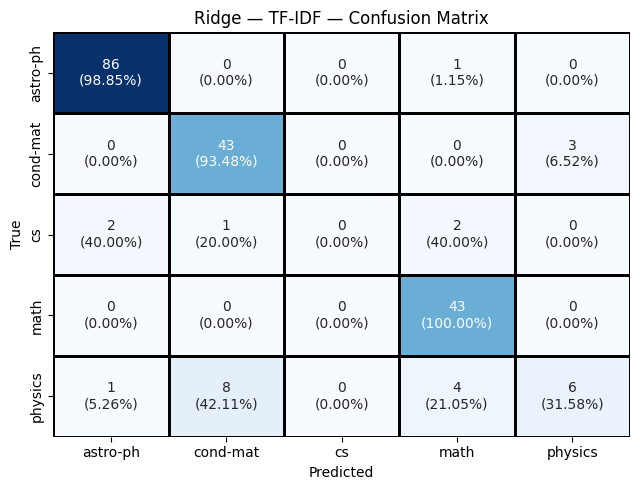

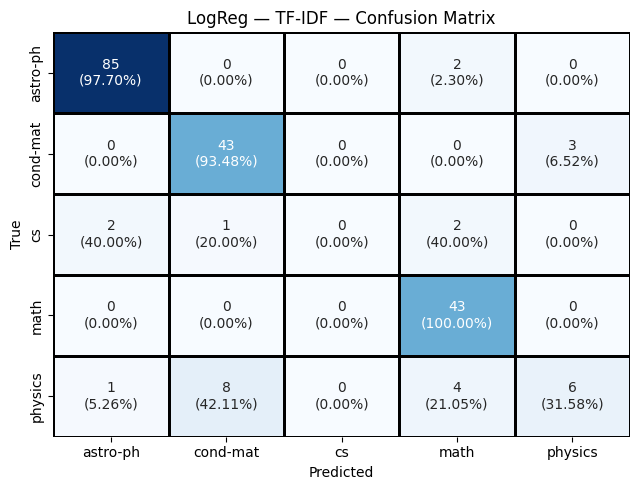

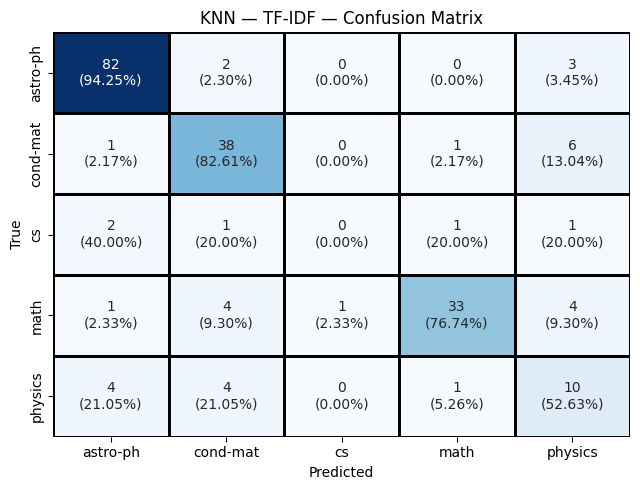

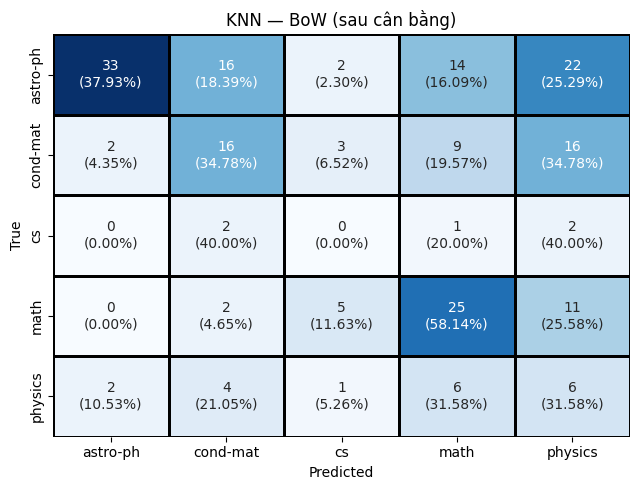

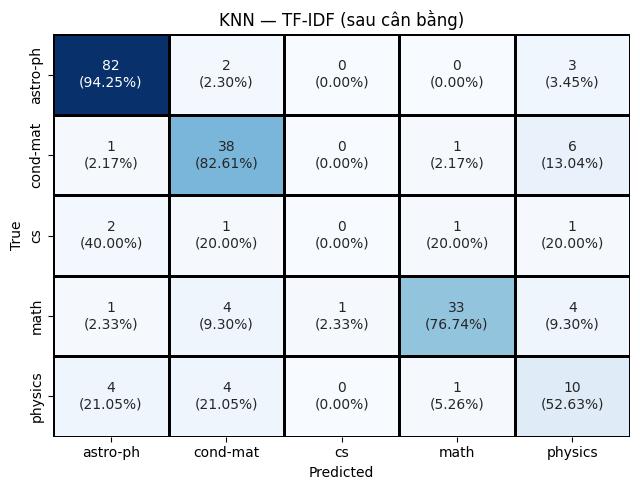

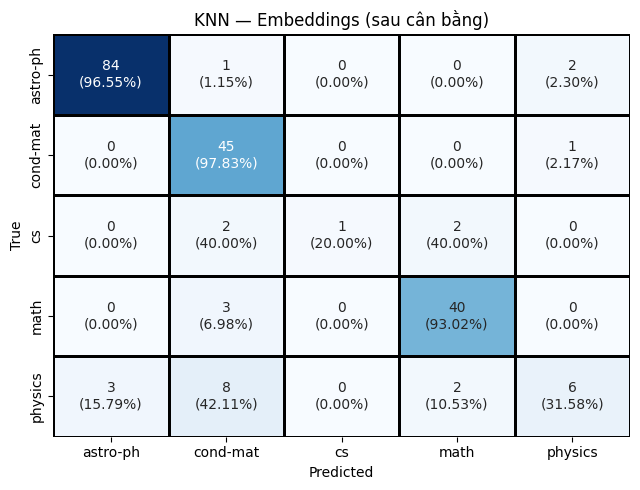

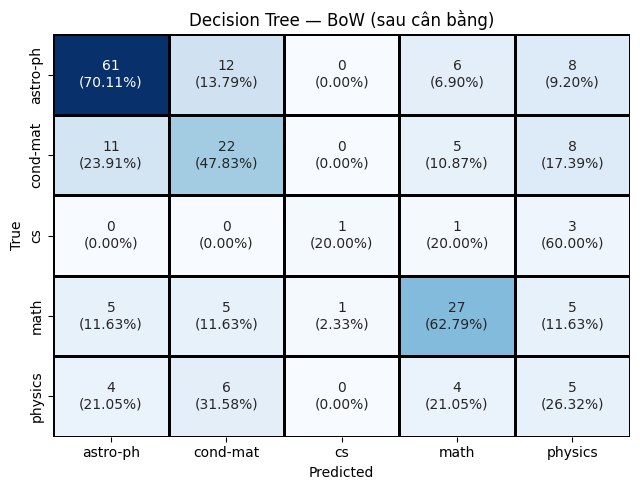

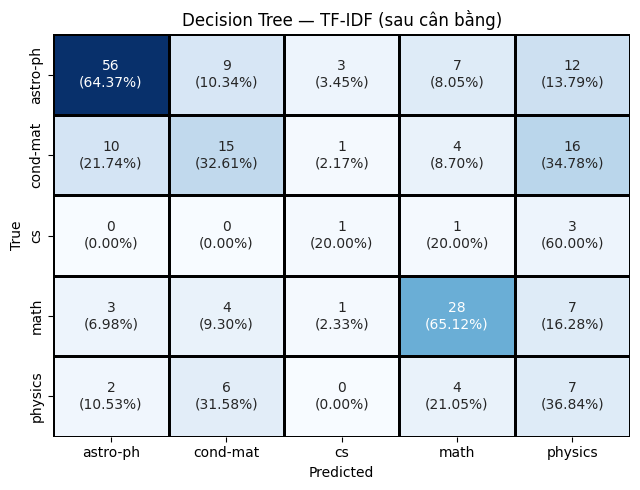

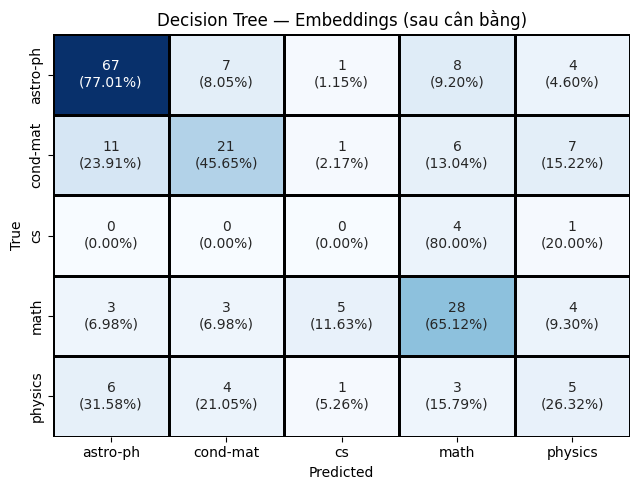

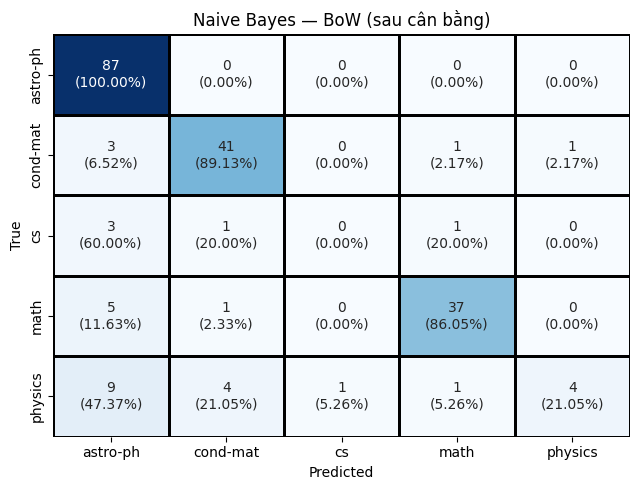

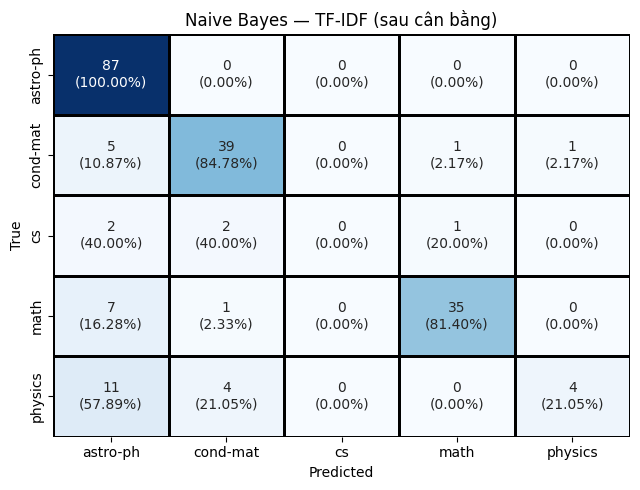

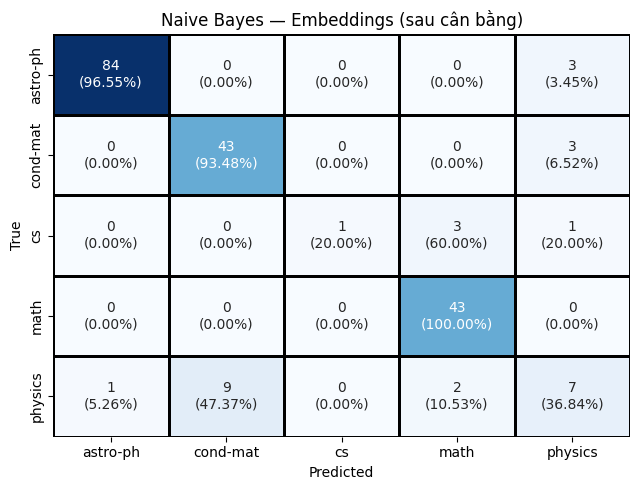

🏆 Top: Ridge — Embeddings | Acc=0.9050 | F1-macro=0.7707
📁 Confusion Matrix đã lưu vào:
 - pdf/Figures/all_models (tất cả mô hình)
 - pdf/Figures/balanced (so sánh cân bằng)
💾 Đã lưu: all_models_metrics.csv


In [40]:
# ---- Chuẩn bị nhãn hiển thị ----
assert 'y_test' in globals(), "Cần có y_test từ bước split dữ liệu."
if 'sorted_labels' not in globals():
    uniq = sorted(set(y_test))
    sorted_labels = [str(i) for i in uniq]
labels_idx = list(range(len(sorted_labels)))

# ---- Helper vẽ Confusion (tạo nếu chưa có) ----
def _cm_annot(cm: np.ndarray) -> np.ndarray:
    cmn = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    ann = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ann[i, j] = f"{cm[i, j]}\n({cmn[i, j]:.2%})"
    return ann


# 1) Thu thập dự đoán mọi mô hình
ALL_CANDIDATES = [
    # KNN
    ("KNN — BoW", "knn_bow_labels"),
    ("KNN — TF-IDF", "knn_tfidf_labels"),
    ("KNN — Embeddings", "knn_emb_labels"),
    # Decision Tree
    ("Decision Tree — BoW", "dt_bow_labels"),
    ("Decision Tree — TF-IDF", "dt_tfidf_labels"),
    ("Decision Tree — Embeddings", "dt_emb_labels"),
    # Naive Bayes
    ("Naive Bayes — BoW", "nb_bow_labels"),
    ("Naive Bayes — TF-IDF", "nb_tfidf_labels"),
    ("Naive Bayes — Embeddings", "nb_emb_labels"),
    # LinearSVC
    ("LinearSVC — BoW", "svc_bow_labels"),
    ("LinearSVC — TF-IDF", "svc_tfidf_labels"),
    ("LinearSVC — Embeddings", "svc_emb_labels"),
    # Logistic Regression
    ("LogReg — BoW", "log_bow_labels"),
    ("LogReg — TF-IDF", "log_tfidf_labels"),
    ("LogReg — Embeddings", "log_emb_labels"),
    # Ridge
    ("Ridge — BoW", "ridge_bow_labels"),
    ("Ridge — TF-IDF", "ridge_tfidf_labels"),
    ("Ridge — Embeddings", "ridge_emb_labels"),
]

pred_map = {}
missing = []
for disp, var in ALL_CANDIDATES:
    if var in globals():
        pred_map[disp] = globals()[var]
    else:
        missing.append(disp)

if not pred_map:
    raise RuntimeError("Không tìm thấy biến dự đoán nào. Hãy chạy cell huấn luyện để tạo các *_labels trước.")

if missing:
    print("ℹ️ Chưa có dự đoán cho:", ", ".join(missing))

# 2) Bảng tổng hợp metrics
rows = []
for name, y_pred in pred_map.items():
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    f1w = f1_score(y_test, y_pred, average="weighted")
    algo, repr_ = name.split(" — ")
    rows.append({
        "model_feature": name,
        "algo": algo,
        "repr": repr_,
        "accuracy": acc,
        "f1_macro": f1m,
        "f1_weighted": f1w
    })

results_df_all = (pd.DataFrame(rows)
                  .sort_values(["f1_macro","accuracy"], ascending=False)
                  .reset_index(drop=True))

print("🏁 Bảng tổng hợp (top 12 theo F1-macro):")
try:
    from IPython.display import display
    display(results_df_all.head(12))
except Exception:
    print(results_df_all.head(12))

# 3) Biểu đồ tổng hợp
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df_all, x="model_feature", y="f1_macro",
            order=results_df_all["model_feature"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("F1-macro"); plt.title("F1-macro theo mô hình–biểu diễn")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df_all, x="model_feature", y="accuracy",
            order=results_df_all["model_feature"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Accuracy"); plt.title("Accuracy theo mô hình–biểu diễn")
plt.tight_layout(); plt.show()

# Biểu đồ theo từng biểu diễn
for repr_name in ["BoW", "TF-IDF", "Embeddings"]:
    sub = results_df_all[results_df_all["repr"] == repr_name].copy()
    if sub.empty:
        continue
    plt.figure(figsize=(7.5, 4))
    sns.barplot(data=sub, x="algo", y="f1_macro",
                order=sub.sort_values("f1_macro", ascending=False)["algo"])
    plt.title(f"F1-macro — {repr_name}")
    plt.xlabel("Mô hình"); plt.ylabel("F1-macro")
    plt.tight_layout(); plt.show()

# 4) Lưu Confusion Matrix cho TẤT CẢ mô hình
def _save_cm(y_true, y_pred, title, save_dir, fname_stub, show=True):
    cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
    ann = _cm_annot(cm)
    plt.figure(figsize=(6.5, 5))
    sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
                xticklabels=sorted_labels, yticklabels=sorted_labels,
                cbar=False, linewidths=1, linecolor='black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout()
    fn = re.sub(r"[^a-zA-Z0-9\-_.]+", "_", fname_stub) + "_cm.pdf"
    path = os.path.join(save_dir, fn)   # <-- dùng tham số save_dir
    plt.savefig(path, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

# Hiển thị tối đa N hình tốt nhất; phần còn lại chỉ lưu
SHOW_TOP_N = 9
order_names = results_df_all["model_feature"].tolist()
for i, name in enumerate(order_names):
    _save_cm(y_test, pred_map[name], title=f"{name} — Confusion Matrix",
             save_dir=PATHS.all_models, fname_stub=name, show=(i < SHOW_TOP_N))

if 'sorted_labels' not in globals():
    assert 'y_test' in globals(), "Cần y_test để suy ra nhãn."
    uniq = sorted(set(y_test))
    sorted_labels = [str(i) for i in uniq]
labels_idx = list(range(len(sorted_labels)))

if '_cm_annot' not in globals():
    def _cm_annot(cm: np.ndarray) -> np.ndarray:
        cmn = cm.astype(float) / np.clip(cm.sum(axis=1, keepdims=True), 1, None)
        ann = np.empty_like(cm).astype(str)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ann[i, j] = f"{cm[i, j]}\n({cmn[i, j]:.2%})"
        return ann

if 'plot_confusion_single' not in globals():
    def plot_confusion_single(y_true, y_pred, class_names=None, title="", save_path=None):
        if class_names is None:
            class_names = sorted_labels
        cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
        ann = _cm_annot(cm)
        plt.figure(figsize=(6.5, 5))
        sns.heatmap(cm, annot=ann, fmt="", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names,
                    cbar=False, linewidths=1, linecolor='black')
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches="tight")
        plt.show()

if 'compare_confusions' not in globals():
    def compare_confusions(y_true, y_pred_pre, y_pred_post, class_names=None,
                           title_pre="Trước cân bằng", title_post="Sau cân bằng",
                           save_path=None):
        if class_names is None:
            class_names = sorted_labels
        labels = range(len(class_names))
        cm_pre  = confusion_matrix(y_true, y_pred_pre,  labels=labels)
        cm_post = confusion_matrix(y_true, y_pred_post, labels=labels)
        ann_pre, ann_post = _cm_annot(cm_pre), _cm_annot(cm_post)

        fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)
        sns.heatmap(cm_pre,  annot=ann_pre,  fmt="", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names,
                    cbar=False, linewidths=1, linecolor='black', ax=axes[0])
        axes[0].set_title(title_pre); axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

        sns.heatmap(cm_post, annot=ann_post, fmt="", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names,
                    cbar=False, linewidths=1, linecolor='black', ax=axes[1])
        axes[1].set_title(title_post); axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches="tight")
        plt.show()


# 5) GIỮ LẠI KHỐI VẼ TRƯỚC/SAU CÂN BẰNG (KNN/DT/NB)
# ====== VẼ KNN ======
if 'knn_bow_labels_pre' in globals():
    compare_confusions(y_test, knn_bow_labels_pre, knn_bow_labels,
                       sorted_labels,
                       title_pre="KNN-BoW (trước cân bằng)", title_post="KNN-BoW (sau cân bằng)",
                       save_path=os.path.join(PATHS.balanced, "knn_bow_compare.pdf"))
else:
    plot_confusion_single(y_test, knn_bow_labels, sorted_labels,
                          "KNN — BoW (sau cân bằng)",
                          save_path=os.path.join(PATHS.balanced, "knn_bow_balanced_cm.pdf"))

if 'knn_tfidf_labels_pre' in globals():
    compare_confusions(y_test, knn_tfidf_labels_pre, knn_tfidf_labels,
                       sorted_labels,
                       title_pre="KNN-TF-IDF (trước cân bằng)", title_post="KNN-TF-IDF (sau cân bằng)",
                       save_path=os.path.join(PATHS.balanced, "knn_tfidf_compare.pdf"))
else:
    plot_confusion_single(y_test, knn_tfidf_labels, sorted_labels,
                          "KNN — TF-IDF (sau cân bằng)",
                          save_path=os.path.join(PATHS.balanced, "knn_tfidf_balanced_cm.pdf"))

if 'knn_emb_labels_pre' in globals():
    compare_confusions(y_test, knn_emb_labels_pre, knn_emb_labels,
                       sorted_labels,
                       title_pre="KNN-Emb (trước cân bằng)", title_post="KNN-Emb (sau cân bằng)",
                       save_path=os.path.join(PATHS.balanced, "knn_emb_compare.pdf"))
else:
    plot_confusion_single(y_test, knn_emb_labels, sorted_labels,
                          "KNN — Embeddings (sau cân bằng)",
                          save_path=os.path.join(PATHS.balanced, "knn_emb_balanced_cm.pdf"))

# ====== VẼ Decision Tree ======
if 'dt_bow_labels_pre' in globals():
    compare_confusions(y_test, dt_bow_labels_pre, dt_bow_labels,
                       sorted_labels,
                       title_pre="DT-BoW (trước cân bằng)", title_post="DT-BoW (sau cân bằng)",
                       save_path=os.path.join(PATHS.balanced, "dt_bow_compare.pdf"))
else:
    plot_confusion_single(y_test, dt_bow_labels, sorted_labels,
                          "Decision Tree — BoW (sau cân bằng)",
                          save_path=os.path.join(PATHS.balanced, "dt_bow_balanced_cm.pdf"))

if 'dt_tfidf_labels_pre' in globals():
    compare_confusions(y_test, dt_tfidf_labels_pre, dt_tfidf_labels,
                       sorted_labels,
                       title_pre="DT-TF-IDF (trước cân bằng)", title_post="DT-TF-IDF (sau cân bằng)",
                       save_path=os.path.join(PATHS.balanced, "dt_tfidf_compare.pdf"))
else:
    plot_confusion_single(y_test, dt_tfidf_labels, sorted_labels,
                          "Decision Tree — TF-IDF (sau cân bằng)",
                          save_path=os.path.join(PATHS.balanced, "dt_tfidf_balanced_cm.pdf"))

if 'dt_emb_labels_pre' in globals():
    compare_confusions(y_test, dt_emb_labels_pre, dt_emb_labels,
                       sorted_labels,
                       title_pre="DT-Emb (trước cân bằng)", title_post="DT-Emb (sau cân bằng)",
                       save_path=os.path.join(PATHS.balanced, "dt_emb_compare.pdf"))
else:
    plot_confusion_single(y_test, dt_emb_labels, sorted_labels,
                          "Decision Tree — Embeddings (sau cân bằng)",
                          save_path=os.path.join(PATHS.balanced, "dt_emb_balanced_cm.pdf"))

# ====== VẼ Naive Bayes ======
if 'nb_bow_labels_pre' in globals():
    compare_confusions(y_test, nb_bow_labels_pre, nb_bow_labels,
                       sorted_labels,
                       title_pre="NB-BoW (trước cân bằng)", title_post="NB-BoW (sau cân bằng)",
                       save_path=os.path.join(PATHS.balanced, "nb_bow_compare.pdf"))
else:
    plot_confusion_single(y_test, nb_bow_labels, sorted_labels,
                          "Naive Bayes — BoW (sau cân bằng)",
                          save_path=os.path.join(PATHS.balanced, "nb_bow_balanced_cm.pdf"))

if 'nb_tfidf_labels_pre' in globals():
    compare_confusions(y_test, nb_tfidf_labels_pre, nb_tfidf_labels,
                       sorted_labels,
                       title_pre="NB-TF-IDF (trước cân bằng)", title_post="NB-TF-IDF (sau cân bằng)",
                       save_path=os.path.join(PATHS.balanced, "nb_tfidf_compare.pdf"))
else:
    plot_confusion_single(y_test, nb_tfidf_labels, sorted_labels,
                          "Naive Bayes — TF-IDF (sau cân bằng)",
                          save_path=os.path.join(PATHS.balanced, "nb_tfidf_balanced_cm.pdf"))

if 'nb_emb_labels_pre' in globals():
    compare_confusions(y_test, nb_emb_labels_pre, nb_emb_labels,
                       sorted_labels,
                       title_pre="NB-Emb (trước cân bằng)", title_post="NB-Emb (sau cân bằng)",
                       save_path=os.path.join(PATHS.balanced, "nb_emb_compare.pdf"))
else:
    plot_confusion_single(y_test, nb_emb_labels, sorted_labels,
                          "Naive Bayes — Embeddings (sau cân bằng)",
                          save_path=os.path.join(PATHS.balanced, "nb_emb_balanced_cm.pdf"))

# 6) Lưu CSV & Kết luận nhanh
csv_path = "all_models_metrics.csv"
results_df_all.to_csv(csv_path, index=False)
lead = results_df_all.iloc[0]
print(f"🏆 Top: {lead['model_feature']} | Acc={lead['accuracy']:.4f} | F1-macro={lead['f1_macro']:.4f}")
print(f"📁 Confusion Matrix đã lưu vào:\n - {PATHS.all_models} (tất cả mô hình)\n - {PATHS.balanced} (so sánh cân bằng)")
print(f"💾 Đã lưu: {csv_path}")